https://github.com/ultralytics/notebooks/blob/main/notebooks/how-to-use-google-gemini-models-for-object-detection-image-captioning-and-ocr.ipynb


  <a href="https://github.com/ultralytics/ultralytics/actions/workflows/ci.yml"><img src="https://github.com/ultralytics/ultralytics/actions/workflows/ci.yml/badge.svg" alt="Ultralytics CI"></a>
  <a href="https://colab.research.google.com/github/ultralytics/notebooks/blob/main/notebooks/how-to-use-google-gemini-models-for-object-detection-image-captioning-and-ocr.ipynb"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"></a>
  
  This notebook demonstrates how to use <a href="https://ai.google.dev/gemini-api/docs/models">Google Gemini models</a>, including the newly released Gemini 2.5 Pro (March 2025), with Ultralytics <a href="https://github.com/ultralytics/ultralytics">YOLO</a> utilities for object detection, image segmentation, and generating visualizations from text prompts such as image captioning.
  
  We aim to provide resources that help you maximize the potential of the Gemini family. If you need assistance, feel free to raise an issue on <a href="https://github.com/ultralytics/ultralytics">GitHub</a> or join our <a href="https://ultralytics.com/discord">Discord</a> community for discussions and support!

# What is Google Gemini?

Google Gemini is a family of multimodal AI models designed to help you process and understand various data types, including text, images, audio, video, and code. The suite includes both Large Language Models (LLMs) and Vision-Language Models (VLMs), enabling you to build versatile AI applications across domains.

In March 2025, Google released `Gemini 2.5 Pro Experimental`, which brings enhanced reasoning capabilities, improved code generation, and stronger  multimodal understanding, making it a powerful tool for vision-based workflows.

<img src="https://github.com/ultralytics/notebooks/releases/download/v0.0.0/gemini-2.5-pro-exp-benchmark.jpg" alt="Gemini 2.5 Pro Experimental Benchmarks" />

## Setup

To get started, we need to install the `ultralytics` and `google-genai` libraries. 🚀

pip install `ultralytics` and [dependencies](https://github.com/ultralytics/ultralytics/blob/main/pyproject.toml) and check software and hardware.

[![PyPI - Version](https://img.shields.io/pypi/v/ultralytics?logo=pypi&logoColor=white)](https://pypi.org/project/ultralytics/) [![Downloads](https://static.pepy.tech/badge/ultralytics)](https://www.pepy.tech/projects/ultralytics) [![PyPI - Python Version](https://img.shields.io/pypi/pyversions/ultralytics?logo=python&logoColor=gold)](https://pypi.org/project/ultralytics/)

In [ ]:
!pip install -U -q google-genai ultralytics

import json

import cv2
import ultralytics
from google import genai
from google.genai import types
from PIL import Image
from ultralytics.utils.downloads import safe_download
from ultralytics.utils.plotting import Annotator, colors

ultralytics.checks()

Ultralytics 8.3.130 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
Setup complete ✅ (2 CPUs, 12.7 GB RAM, 41.4/112.6 GB disk)


## Inference function

Let’s configure the Gemini client to accept an image and perform tasks based on your text prompts. Find more information about [Gemini models](https://ai.google.dev/gemini-api/docs/models). To get started, generate your API key by logging into <a href="https://aistudio.google.com/">Google AI Studio</a>. 🚀

The inference function will be used throughout the notebook to perform various operations using the Gemini model.

In [ ]:
try:
  import google.colab
  IN_COLAB = True
except:
  IN_COLAB = False

if IN_COLAB:
  from google.colab import userdata
  api_key = userdata.get('GOOGLE_API_KEY')

In [ ]:
# Initialize the Gemini client with your API key
client = genai.Client(api_key=api_key)


def inference(image, prompt, temp=0.5):
    """
    Performs inference using Google Gemini 2.5 Pro Experimental model.

    Args:
        image (str or genai.types.Blob): The image input, either as a base64-encoded string or Blob object.
        prompt (str): A text prompt to guide the model's response.
        temp (float, optional): Sampling temperature for response randomness. Default is 0.5.

    Returns:
        str: The text response generated by the Gemini model based on the prompt and image.
    """
    response = client.models.generate_content(
        model="gemini-2.5-pro-exp-03-25",
        contents=[prompt, image],  # Provide both the text prompt and image as input
        config=types.GenerateContentConfig(
            temperature=temp,  # Controls creativity vs. determinism in output
        ),
    )

    return response.text  # Return the generated textual response

## Download and read the Image  



For testing, we'll fetch `gemini-image1.jpg` from [Ultralytics](https://ultralytics.com/) [notebooks assets](https://github.com/ultralytics/notebooks/releases/tag/v0.0.0) and use it for tasks like image captioning, object detection, image segmentation, and OCR. Feel free to use any image of your choice.

In [ ]:
def read_image(filename=None):
    if filename is not None:
        image_name = filename
    else:
        image_name = "bus.jpg"  # or "zidane.jpg"

    # Download the image
    safe_download(f"https://github.com/ultralytics/notebooks/releases/download/v0.0.0/{image_name}")

    # Read image with opencv
    image = cv2.cvtColor(cv2.imread(f"/content/{image_name}"), cv2.COLOR_BGR2RGB)

    # Extract width and height
    h, w = image.shape[:2]

    # # Read the image using OpenCV and convert it into the PIL format
    return Image.fromarray(image), w, h

![Input image for testing gemini-2.5-pro model](https://github.com/ultralytics/notebooks/releases/download/v0.0.0/gemini-inference-image.jpg)

## Results formatting

You can use this function to clean the raw string output by removing Markdown formatting (like ```json), so it can be safely parsed as JSON for bounding box extraction and plotting. 🧼

In [ ]:
def clean_results(results):
    """Clean the results for visualization."""
    return results.strip().removeprefix("```json").removesuffix("```").strip()

## Object detection

Gemini models support object detection, helping you efficiently identify and recognize multiple objects within an image. 😀

100%|██████████| 314k/314k [00:00<00:00, 14.0MB/s]


100%|██████████| 755k/755k [00:00<00:00, 18.5MB/s]


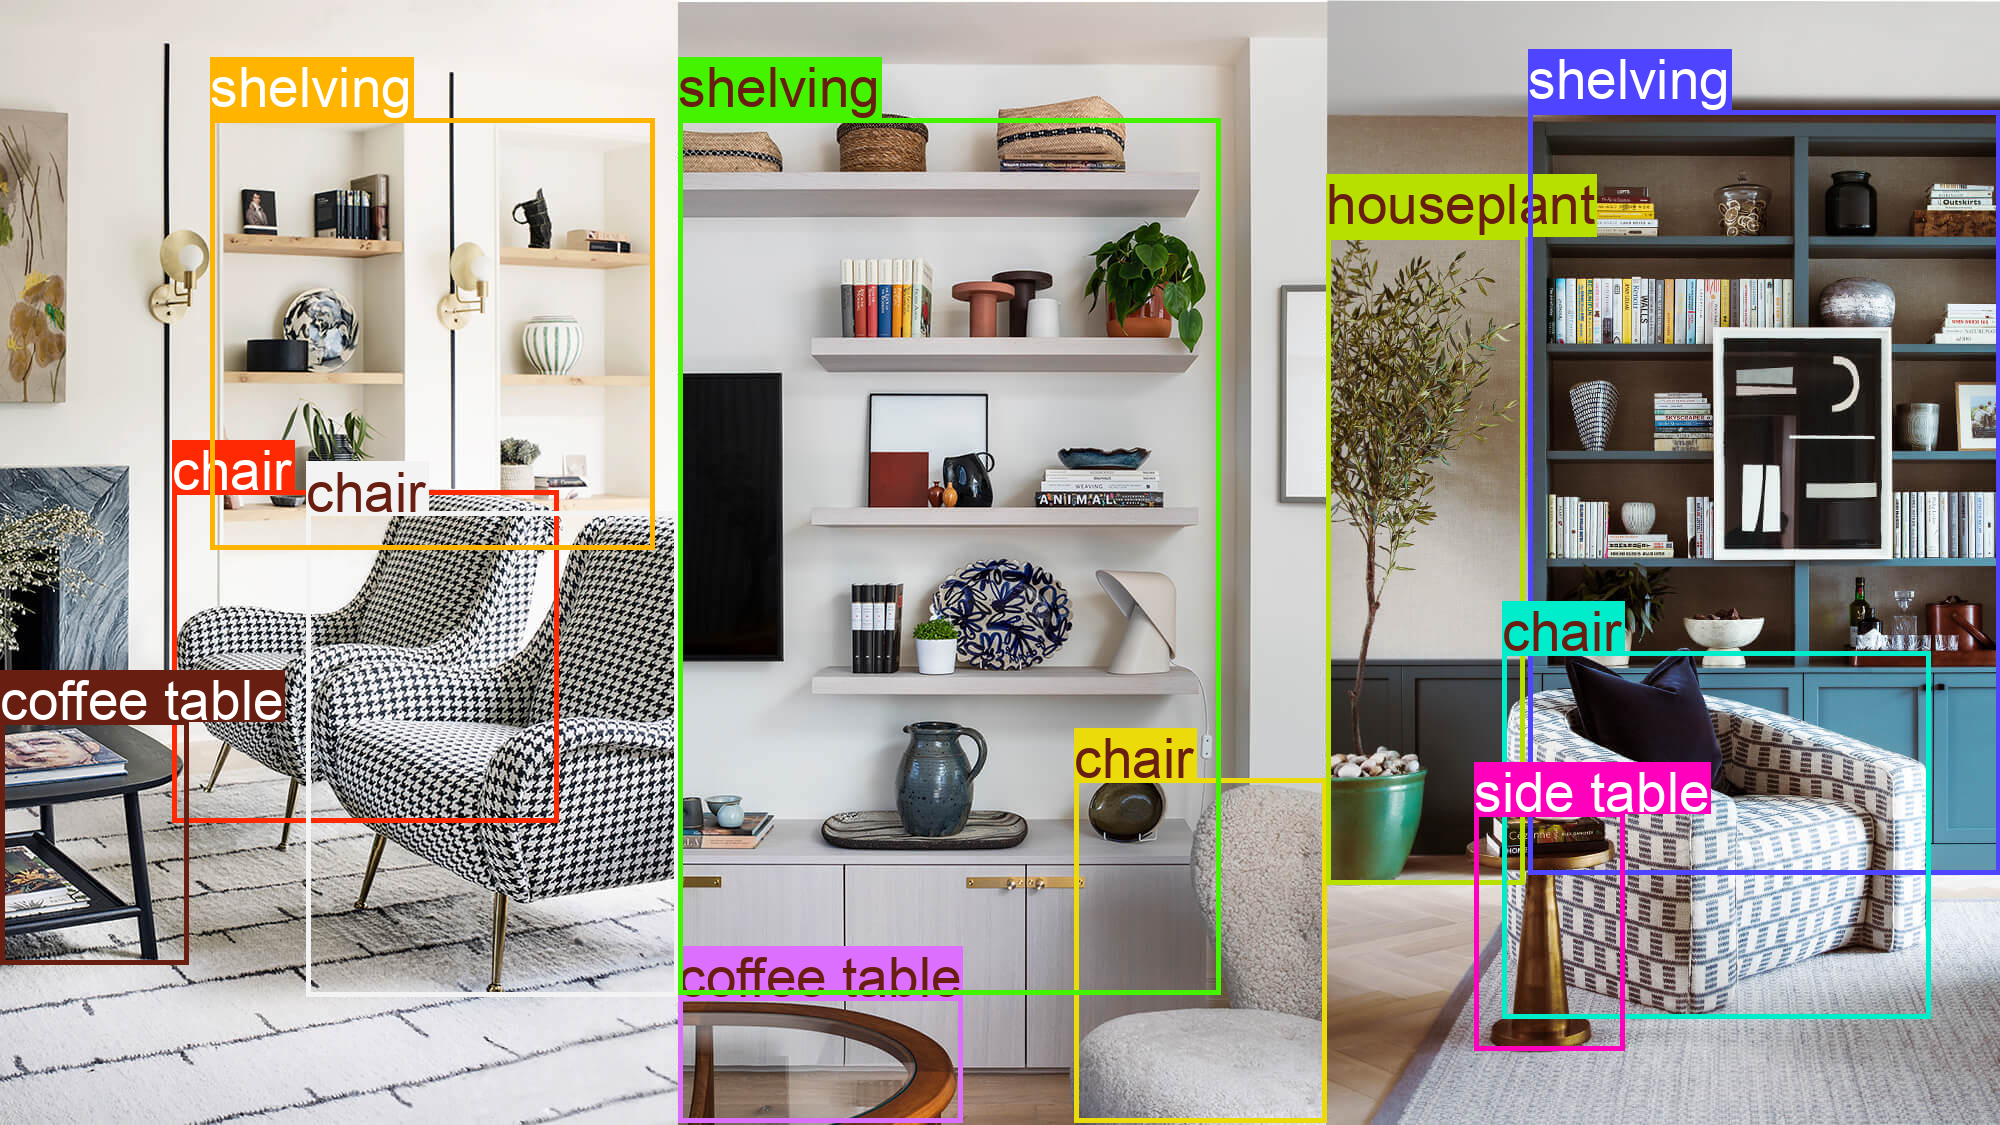

In [ ]:
# Define the text prompt
prompt = """
Detect the 2d bounding boxes of objects in image.
"""

# Fixed, plotting function depends on this.
output_prompt = "Return just box_2d and labels, no additional text."

image, w, h = read_image("gemini-image1.jpg")  # Read img, extract width, height

results = inference(image, prompt + output_prompt)  # Perform inference

cln_results = json.loads(clean_results(results))  # Clean results, list convert

annotator = Annotator(image)  # initialize Ultralytics annotator

for idx, item in enumerate(cln_results):
    # By default, gemini model return output with y coordinates first.
    # Scale normalized box coordinates (0–1000) to image dimensions
    y1, x1, y2, x2 = item["box_2d"]  # bbox post processing,
    y1 = y1 / 1000 * h
    x1 = x1 / 1000 * w
    y2 = y2 / 1000 * h
    x2 = x2 / 1000 * w

    if x1 > x2:
        x1, x2 = x2, x1  # Swap x-coordinates if needed
    if y1 > y2:
        y1, y2 = y2, y1  # Swap y-coordinates if needed

    annotator.box_label([x1, y1, x2, y2], label=item["label"], color=colors(idx, True))

Image.fromarray(annotator.result())  # display the output

## Reasoning capabilities

With Gemini models, you can tackle complex tasks using advanced reasoning that understands context and delivers more precise results. 🧠

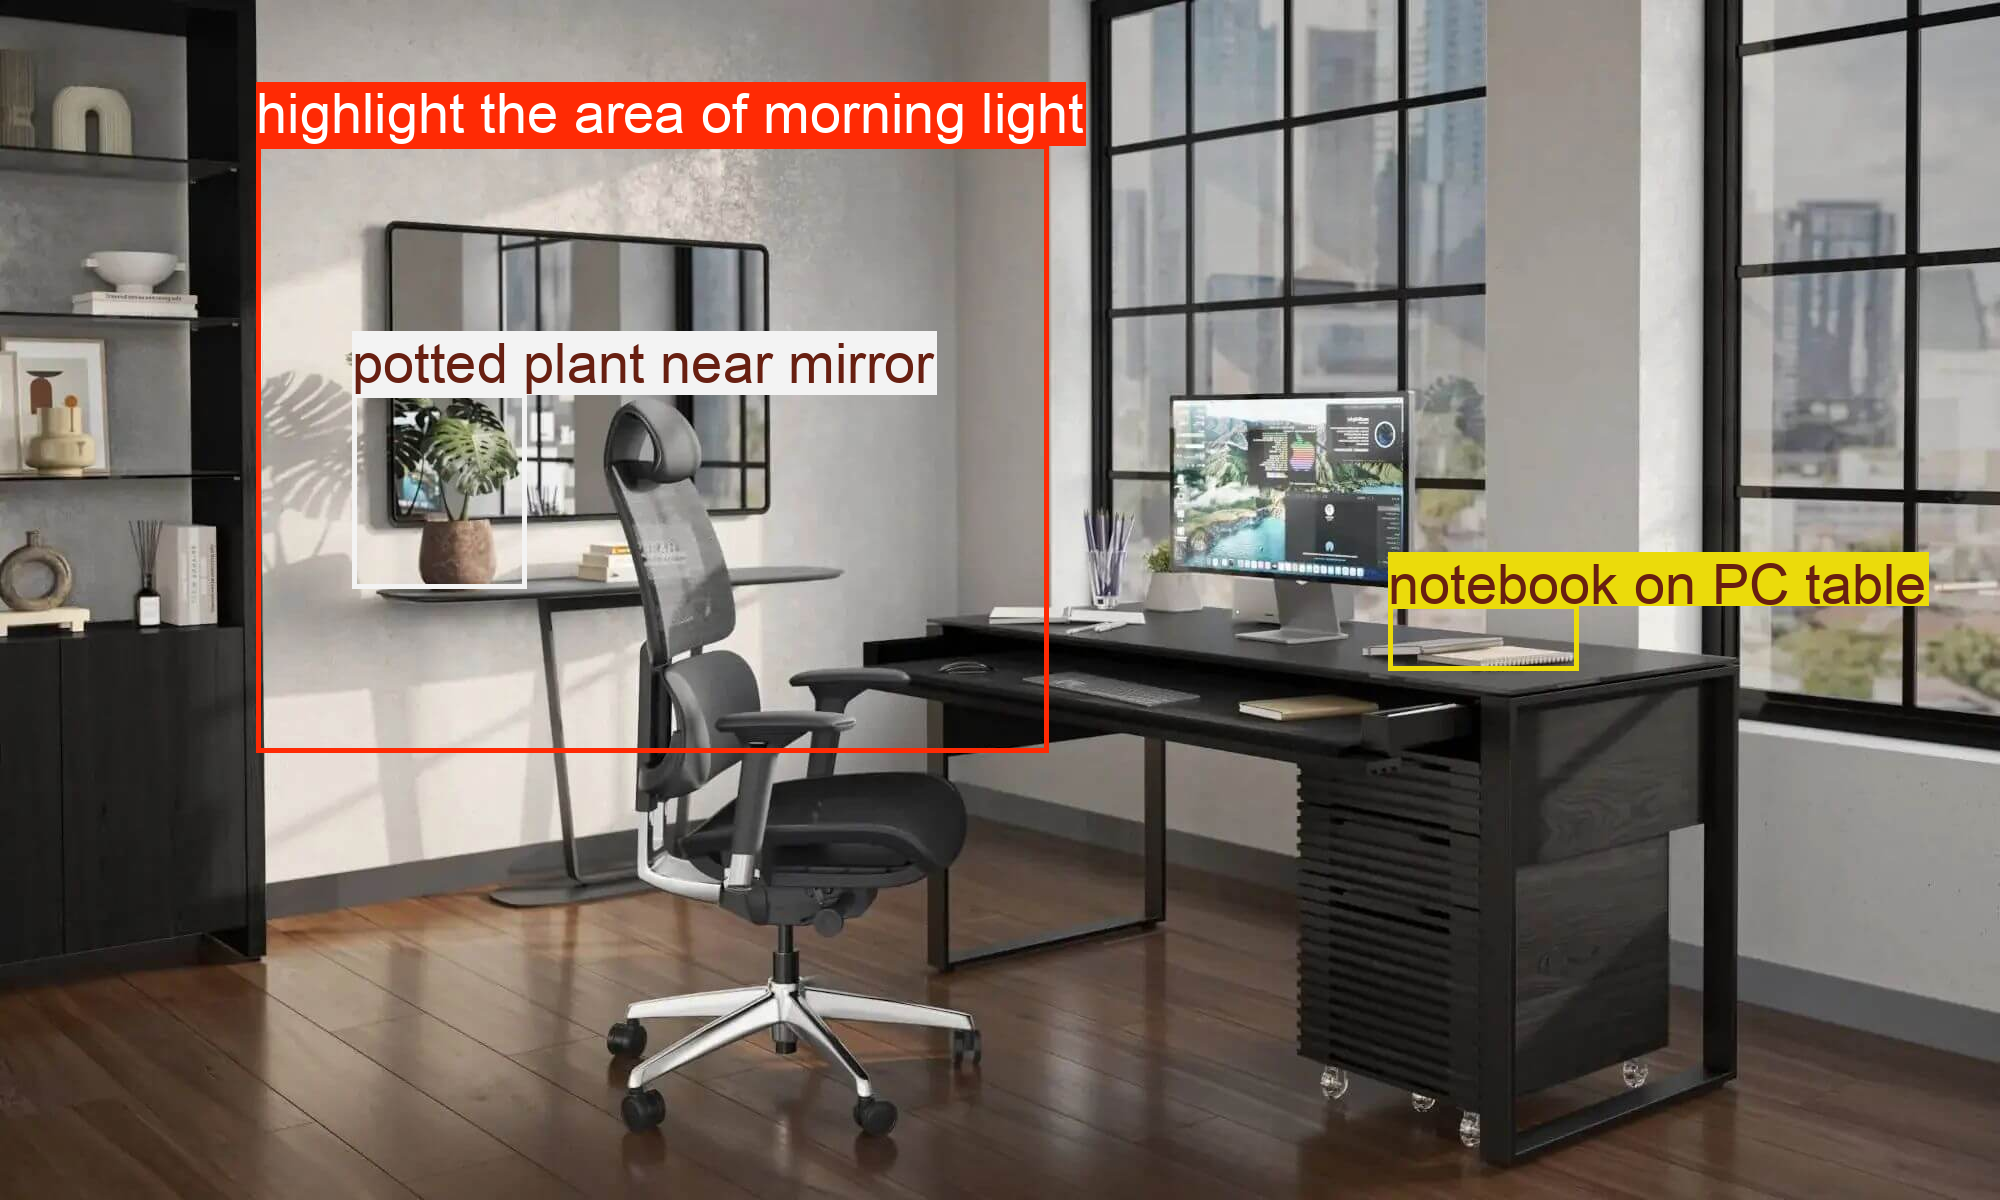

In [ ]:
# Define the text prompt
prompt = """
Detect the 2d bounding box around:
highlight the area of morning light +
notebook on PC table
potted plant near mirror.
"""

# Fixed, plotting function depends on this.
output_prompt = "Return just box_2d and labels, no additional text."

image, w, h = read_image("gemini-image2.jpg")  # Read image and extract width, height

results = inference(image, prompt + output_prompt)

# Clean the results and load results in list format
cln_results = json.loads(clean_results(results))

annotator = Annotator(image)  # initialize Ultralytics annotator

for idx, item in enumerate(cln_results):
    # By default, gemini model return output with y coordinates first.
    # Scale normalized box coordinates (0–1000) to image dimensions
    y1, x1, y2, x2 = item["box_2d"]  # bbox post processing,
    y1 = y1 / 1000 * h
    x1 = x1 / 1000 * w
    y2 = y2 / 1000 * h
    x2 = x2 / 1000 * w

    if x1 > x2:
        x1, x2 = x2, x1  # Swap x-coordinates if needed
    if y1 > y2:
        y1, y2 = y2, y1  # Swap y-coordinates if needed

    annotator.box_label([x1, y1, x2, y2], label=item["label"], color=colors(idx, True))

Image.fromarray(annotator.result())  # display the output

## Image captioning  

You can use Gemini models for image captioning to generate meaningful text descriptions that summarize the content of an image. 📝

In [ ]:
# Define the text prompt
prompt = """
What's inside the image, generate a detailed captioning in the form of short
story, Make 4-5 lines and start each sentence on a new line.
"""

image, _, _ = read_image("gemini-image4.jpg")  # Read image and extract width, height

print(inference(image, prompt))  # Display the results

100%|██████████| 153k/153k [00:00<00:00, 7.74MB/s]


Golden light spilled across the wooden desk, heralding a new day.
The laptop sat open, its screen dark, while steam curled gently from a warm, pink mug.
Nearby, a tablet and a closed notebook lay in wait, companions to the leafy plants soaking up the sun.
This tranquil home office promised a morning of focused work and quiet contemplation.


<img src="https://github.com/ultralytics/notebooks/releases/download/v0.0.0/gemini-inference-image-captioning.jpg">

## OCR

Gemini models also support Optical Character Recognition (OCR), helping you detect and extract text from images with speed and accuracy. 🚀

100%|██████████| 73.7k/73.7k [00:00<00:00, 5.24MB/s]


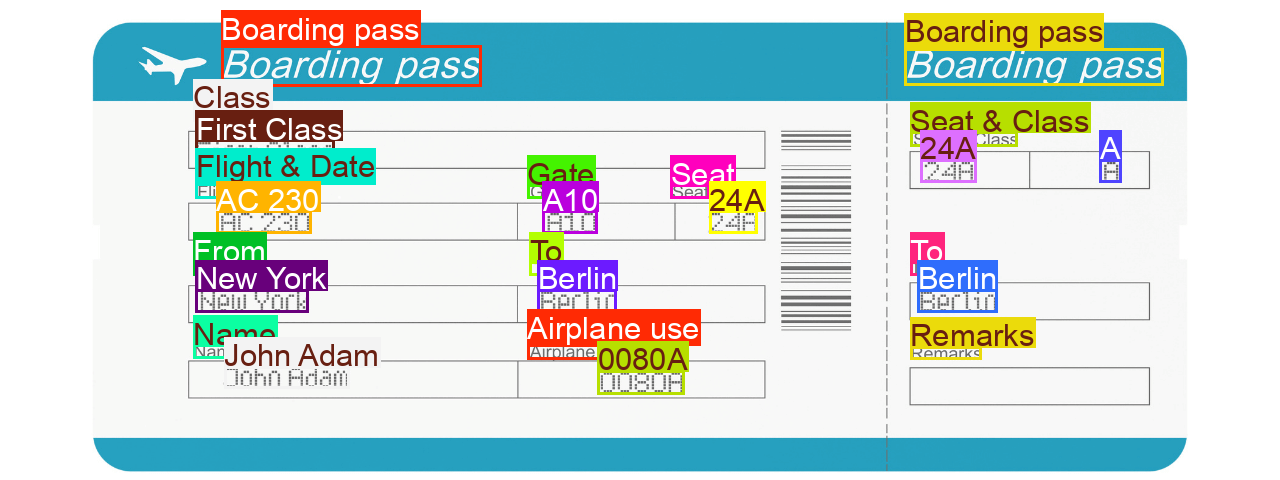

In [ ]:
# Define the text prompt
prompt = """
Extract the text from the image
"""

# Fixed, plotting function depends on this.
output_prompt = """
Return just box_2d which will be location of detected text areas + label"""

image, w, h = read_image("gemini-image3.png")  # Read image and extract width, height

results = inference(image, prompt + output_prompt)

# Clean the results and load results in list format
cln_results = json.loads(clean_results(results))

annotator = Annotator(image)  # initialize Ultralytics annotator

for idx, item in enumerate(cln_results):
    # By default, gemini model return output with y coordinates first.
    # Scale normalized box coordinates (0–1000) to image dimensions
    y1, x1, y2, x2 = item["box_2d"]  # bbox post processing,
    y1 = y1 / 1000 * h
    x1 = x1 / 1000 * w
    y2 = y2 / 1000 * h
    x2 = x2 / 1000 * w

    if x1 > x2:
        x1, x2 = x2, x1  # Swap x-coordinates if needed
    if y1 > y2:
        y1, y2 = y2, y1  # Swap y-coordinates if needed

    annotator.box_label([x1, y1, x2, y2], label=item["label"], color=colors(idx, True))

Image.fromarray(annotator.result())  # display the output

## Additional Resources  

✅ Learn more about Gemini 2.5: [here](https://blog.google/technology/google-deepmind/gemini-model-thinking-updates-march-2025/)  
✅ Ultralytics Annotator: [here](https://docs.ultralytics.com/reference/utils/plotting/)

🌟 Explore the [Ultralytics Notebooks](https://github.com/ultralytics/notebooks/) and give them a star to boost your AI journey! 🚀

Built with 💙 by [Ultralytics](https://ultralytics.com/)  